In [1]:

import timm # !pip install git+https://github.com/rwightman/pytorch-image-models
from tqdm import tqdm
import pytorch_lightning
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision
from torchvision import datasets, transforms

from torchmetrics.functional.classification.accuracy import accuracy
from torchmetrics.functional import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

# from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import collections

import numpy as np
import torchmetrics

In [2]:
pytorch_lightning.__version__

'1.4.1'

In [3]:



import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath




In [4]:
def random_erase(pilimg):
    img = np.array(pilimg)

    h,w,_ = img.shape

    xx = np.random.random(2)
    xmin = int(min(xx)*w)
    xmax = int(max(xx)*w)

    yy = np.random.random(2)
    ymin = int(min(yy)*h)
    ymax = int(max(yy)*h)

    # print(ymin,ymax,xmin,xmax)

    img[ymin:ymax,xmin:xmax,:]=0

    return Image.fromarray(img)

In [5]:
class AgeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, path, transform, erase=False):
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform
        self.path = path
        
        self.erase=erase



        self.Ages = ['0-10',
 '10-20',
 '20-30',
 '30-40',
 '40-50',
 '50-60',
 '60-70',
 '70-80',
 '80-90',
 '90-100']

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.path + '/' + self.dataframe.iloc[idx, 0] + '.jpg'
        image = Image.open(img_name)
        
        age = self.Ages.index(self.dataframe.iloc[idx, 1])
        age = torch.Tensor(np.array([age]).reshape(-1)).long()
        
        if self.erase:
            image = random_erase(image)

        if self.transform is not None:
            image = self.transform(image)
            
        sample = {'image': image, 'age': age, 'fname':self.dataframe.iloc[idx, 0]}

        return sample

    def get_counts(self):
        return collections.defaultdict(int, self.dataframe.age.value_counts().to_dict())


In [6]:

def ordinal_regression(predictions, targets):
    """Ordinal regression with encoding as in https://arxiv.org/pdf/0704.1028.pdf"""

    # Create out modified target with [batch_size, num_labels] shape
    modified_target = torch.zeros_like(predictions)

    # Fill in ordinal target function, i.e. 0 -> [1,0,0,...]
    for i, target in enumerate(targets):
        #modified_target[i, 0:target] = 1
        modified_target[i, 0:target+1] = 1

        
    mse = nn.MSELoss(reduction='mean')(predictions, modified_target)

    
#     mse = nn.MSELoss(reduction='none')(predictions, modified_target)
#     weights=torch.Tensor([1.0,0.3,0.3,0.3,1.0]).type_as(mse)
#     mse = torch.mean(torch.mul(mse, weights))

    return mse

def prediction2label(pred: np.ndarray):
    """Convert ordinal predictions to class labels, e.g.
    
    [0.9, 0.1, 0.1, 0.1] -> 0
    [0.9, 0.9, 0.1, 0.1] -> 1
    [0.9, 0.9, 0.9, 0.1] -> 2
    etc.
    """
    return torch.clamp((pred > 0.5).cumprod(axis=1).sum(axis=1,keepdims=True)-1, min=0)

In [7]:
# def balanced_accuracy(y_true, y_pred, sample_weight=None):
#     y_true = y_true.detach().cpu().numpy().astype(int) # compile model with run_eagerly=True
#     y_pred = np.argmax(y_pred.detach().cpu().numpy(),axis=1).astype(int)
#     return balanced_accuracy_score(y_true, y_pred)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [8]:

def getModel(backbone, train_size):
    model = nn.ModuleList([timm.create_model(backbone, pretrained=True, num_classes=0),])
    in_features = model[0](torch.rand(1,3,train_size, train_size)).shape[-1]

    model.append(nn.Sequential(torch.nn.LayerNorm([in_features, ]),
                          nn.Dropout(0.5),
#                           nn.Linear(in_features, 128),
#                           nn.LeakyReLU(),
                          nn.Linear(in_features, 10),
                          nn.Sigmoid()))
                              
    return model

In [9]:
class AgeClassification(LightningModule):
    def __init__(self, net, train_size, test_size, transform_train, transform_val, batch_size=16, lr=1e-3,
                pt_fname=None, ckpt_fname=None):
        super().__init__()
        
        self.save_hyperparameters('batch_size', 'lr', 'train_size', 'test_size')

        self.train_csv = 'data/train.csv'
        self.val_csv = 'data/val.csv'
        self.classes = ['0-10', '20-30', '40-50', '70-80', '80-90', '30-40', '50-60', '10-20', '60-70', '90-100']
        self.batch_size = batch_size
        self.train_size = train_size
        self.test_size = test_size

        self.example_input_array = torch.rand(1, 3, self.train_size, self.train_size)

        self.transform_train = transform_train
        self.transform_val = transform_val
        
        self.setup()
        
#         self.loss=ordinal_regression
        self.loss=nn.CrossEntropyLoss(label_smoothing=0.1)
        self.lr = lr
        self.net = net

    def custom_histogram_adder(self):
        for name,params in self.named_parameters():
            self.logger.experiment.add_histogram(name,params,self.current_epoch)
    
    def freeze(self, epochs):
        for i,param in enumerate(self.net[0].parameters()):
            param.requires_grad = False
        for i,param in enumerate(self.net[1].parameters()):
            param.requires_grad = True

        self.epochs = epochs
    
    def unfreeze(self, epochs):
        for i,param in enumerate(self.net[0].parameters()):
            param.requires_grad = True
        for i,param in enumerate(self.net[1].parameters()):
            param.requires_grad = True
        self.epochs = epochs
        
    def freeze_bn(self):
        for module in self.modules():
            # print(module)
            if isinstance(module, nn.BatchNorm1d) or isinstance(module, nn.BatchNorm2d):
                # print(module,'==> FREEZE!!!')
                if hasattr(module, 'weight'):
                    module.weight.requires_grad_(False)
                if hasattr(module, 'bias'):
                    module.bias.requires_grad_(False)
                module.eval()

    def forward(self, x):
        x = self.net[0](x)
        return self.net[1](x)
    
    def on_fit_start(self):
        self.logger.log_hyperparams(self.hparams,
                                    metrics=#{})
        dict.fromkeys(['hp/val/acc/age'], float('NaN')))
    
    def _step(self, mode, batch, batch_idx):
        x = batch['image']
#         y = batch['age']
        y = batch['age'][:,0]
        
        all_logits = self(x)
        
        loss = self.loss(all_logits, y)
#         acc = accuracy(prediction2label(all_logits), y.long())
#         f1 = torchmetrics.F1Score(num_classes=len(self.classes))(prediction2label(all_logits).detach().cpu(), y.long().detach().cpu())
        acc = accuracy(all_logits, y.long())
        f1 = torchmetrics.F1Score(num_classes=len(self.classes))(all_logits.detach().cpu(), y.long().detach().cpu())
        
        d = {}
        
        if mode=='val':
#             l = all_logits.detach().cpu()
            l = all_logits.detach().cpu()
            n = 'age'
            d['val/%s/target'%n]=y
#             d['val/%s/pred'%n]=prediction2label(l)
            d['val/%s/pred'%n]=torch.argmax(l,axis=1)
                
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log(mode+'/loss/age', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(mode+'/acc/age', acc, on_step=False, on_epoch=True, prog_bar=(mode=='val'), logger=True)
        self.log(mode+'/f1', f1, on_step=False, on_epoch=True, prog_bar=(mode=='val'), logger=True)


        # d[mode+'_loss']+=loss
        d['loss'] = loss

        d['loss_age'] = loss
        d['acc_age'] = acc.detach()
        d['f1'] = f1.detach()
        
        return d
    def training_epoch_end(self, outputs):
        # logging histograms
        self.custom_histogram_adder()

    def validation_step_end(self, batch_parts):
        pass
#         # DP - size=0 problem https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html#validating-with-dataparallel
#         print('\n\nvalidation_step_end',type(batch_parts),len(batch_parts))
#         print('\n')

    def validation_epoch_end(self, outputs):
#         print('validation_epoch_end len=%d'%(len(outputs)))#, outputs)
#         print('='*80)
#         for output in outputs:
#             for k in output:
# #                 print(k, output[k], output[k].shape)
#                 print(k, output[k].shape)
#             print('-'*80)
        if len(outputs)==0:
            return
        fig = plt.figure(figsize=(30,20))
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        preds = torch.cat([tmp['val/age/pred'] for tmp in outputs],0)
        targets = torch.cat([tmp['val/age/target'] for tmp in outputs],0)

        cm = confusion_matrix(preds.cpu(), targets.cpu(), num_classes=len(self.classes),
                              normalize='true').cpu()
        #https://torchmetrics.readthedocs.io/en/stable/references/functional.html#confusion-matrix-func

        df_cm = pd.DataFrame(cm.numpy(), index = self.classes, columns=self.classes)
        sns.heatmap(df_cm, annot=True, fmt='.2f',cmap='Oranges')
        plt.ylabel("True")
        plt.xlabel("Predicted")
        plt.close(fig)

        age_valacc = torch.stack([x['acc_age'] for x in outputs]).mean()
        self.log('hp/val/acc/age', age_valacc)
        
        f1 = torch.stack([x['f1'] for x in outputs]).mean()
        self.log('hp/val/f1', f1)

        self.logger.experiment.add_figure('val/cm', fig, self.current_epoch)
#         if self.current_epoch==0:
#             self.plot_train_examples()
#             self.plot_val_examples()
#             self.plot_counts()
#             self.plot_val_counts()
#             self.log('train/samples/total', len(self.train_dataset))
#             self.log('val/samples/total', len(self.val_dataset))
#             for i in range(len(self.counts)):
#                 for j in range(len(self.classes[i])):
#                     print('train/samples/%s'%self.classes[i][j],self.counts[i][j])
#                     self.log('train/samples/%s'%self.classes[i][j],self.counts[i][j])
#             for i in range(len(self.val_counts)):
#                 for j in range(len(self.classes[i])):
#                     self.log('val/samples/%s'%self.classes[i][j],self.val_counts[i][j])

        
    def setup(self, stage=None):
        self.train_dataset = AgeDataset(self.train_csv, 'data/train', transform=self.transform_train, erase=True)
        self.val_dataset = AgeDataset(self.val_csv, 'data/val', transform=self.transform_val, erase=False)

        self.counts = self.train_dataset.get_counts()
        self.val_counts = self.val_dataset.get_counts()
        
        print('self.counts',self.counts)
        print('self.val_counts',self.val_counts)

    def plot_counts(self):
        fig = plt.figure(figsize=(20,6))
        print(self.classes, [self.counts[_] for _ in  self.classes])
        plt.bar(self.classes, [self.counts[_] for _ in  self.classes])
        plt.close(fig)
        self.logger.experiment.add_figure('train/dataset/counts', fig, 0)
    
    def plot_val_counts(self):
        fig = plt.figure(figsize=(20,6))
        print(self.classes, [self.val_counts[_] for _ in  self.classes])
        plt.bar(self.classes, [self.val_counts[_] for _ in  self.classes])
        plt.close(fig)
        self.logger.experiment.add_figure('val/dataset/counts', fig, 0)
    
    def plot_examples(self, ds):
        fig = plt.figure(figsize=(10,10))
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        for i,b in enumerate(ds):
            plt.subplot(3,3,i+1)
            img = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(b['image'])
            plt.imshow(img.permute(1,2,0))
            plt.axis('off')
            t = dict(b)
            del t['fname']
            # plt.title(', '.join([self.classes[i][int(v)] for i,v in enumerate(t.values())]))
            for k in t:
                t[k] = str(t[k].cpu().numpy().tolist())
            plt.title('\n'.join(["%s %s"%(k, t[k])for k in t]))
            if i>=8:
                break
        return fig
    
    def plot_train_examples(self):
        fig = self.plot_examples(self.train_dataset)
        plt.suptitle('Training samples')
        if self.logger is not None:
            plt.close(fig)
            self.logger.experiment.add_figure('train/dataset/samples', fig, 0)
        
    def plot_val_examples(self):
        fig = self.plot_examples(self.val_dataset)
        plt.suptitle('Validation samples')
        if self.logger is not None:
            plt.close(fig)
            self.logger.experiment.add_figure('val/dataset/samples', fig, 0)
    
    def training_step(self, batch, batch_idx):
        return self._step('train', batch, batch_idx)
    
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            output = self._step('val', batch, batch_idx)
            return output
    
    def configure_optimizers(self):
        d=dict()
        d["optimizer"] = torch.optim.RAdam(self.parameters(), lr=self.lr)
#         d["optimizer"] = torch.optim.SGD(self.parameters(), lr=self.lr)


        print("len(self.train_dataset):",len(self.train_dataset))
        print("self.batch_size:",self.batch_size)
        total_steps = self.epochs * len(self.train_dataset)//self.batch_size
        print("total_steps:",total_steps) #drop last = True

        pct_start = 0.1
        div_factor = 100
        final_div_factor = 100
        d["lr_scheduler"] = {"scheduler": torch.optim.lr_scheduler.OneCycleLR(d['optimizer'],
                                            max_lr=self.lr,
                                            total_steps=total_steps,
                                            pct_start=pct_start,
                                            div_factor=div_factor,
                                            final_div_factor=final_div_factor),
                            "frequency": 1,
                            'interval': 'step'
                            }
        return d
    
    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=0, shuffle=True,drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0)

In [10]:
if torch.cuda.device_count()>0:
    print("Torch             :",torch.__version__)
    print("CUDA devices count:",torch.cuda.device_count())
    print("1st dev name      :", torch.cuda.get_device_name(0))
else:
    print("\n\nNO CUDA!!!\n\n")

Torch             : 1.10.2
CUDA devices count: 1
1st dev name      : GeForce RTX 2070 with Max-Q Design


In [11]:
batch_size_freezed = 256
batch_size_unfreezed = 4
train_size=384
test_size=384

In [12]:


augmentations = A.Compose(
                [#A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.5, rotate_limit=20, p=0.8),
                A.RGBShift(r_shift_limit=40, g_shift_limit=40, b_shift_limit=40, p=0.9),
                A.HorizontalFlip(p=0.5),
                A.OneOf([
                    A.OpticalDistortion(p=0.5),
                    A.GridDistortion(p=.5),
                    A.PiecewiseAffine(p=0.5),
                ], p=0.5),
                A.OneOf([
                    A.CLAHE(clip_limit=2),
                    A.Sharpen(),
                    A.Emboss(),
                    A.RandomBrightnessContrast(),
                ], p=0.5),
#                 A.OneOf([A.Solarize(),
#                          A.Superpixels(),
#                          A.Posterize()]),
                A.RandomGamma(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
#                 A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.3),
#                 A.ImageCompression(quality_lower=20, quality_upper=90,p=0.5)
                ])

transform_train = transforms.Compose([transforms.Resize([train_size, train_size]),
                              transforms.Lambda(lambda img: np.array(img)),
                              transforms.Lambda(lambda img: augmentations(image=img)['image']),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                     ])

transform_val = transforms.Compose([
    transforms.Resize([test_size, test_size]),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


torch.Size([3, 384, 384])
(384, 384, 3)


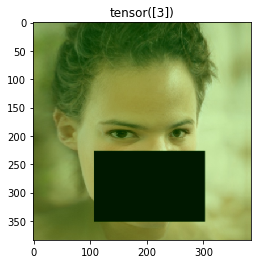

In [13]:
for b in AgeDataset('data/train.csv', 'data/train', transform=transform_train, erase=True):
    plt.title(b['age'])
    print(b['image'].shape)
    img = torch.permute(UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(b['image']), (1,2,0)).numpy()
    print(img.shape)
    plt.imshow(img)
    break

In [14]:
# backbone='xcit_tiny_12_p8_384_dist'
backbone='xcit_tiny_24_p8_384_dist'
net = getModel(backbone, train_size)

In [15]:
freezed_epochs = 10
unfreezed_epochs = 200
lr_freezed = 0.03
lr_unfreezed = 3e-6

In [16]:
age_model = AgeClassification(net, train_size=train_size, test_size=test_size,
                                transform_train=transform_train,
                                transform_val=transform_val,
                                lr=lr_freezed,
                                batch_size=batch_size_freezed)


age_model.freeze(freezed_epochs)
lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='step',
                                                            log_momentum=True)
logger = TensorBoardLogger("lightning_logs", name=backbone, default_hp_metric=False, log_graph=True)

trainer = Trainer(gpus=1,
                  max_epochs=freezed_epochs,
                  amp_backend='native',
                  precision=16,
                  callbacks=[lr_monitor],
                  logger=logger)
trainer.fit(age_model)
del trainer



Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


self.counts defaultdict(<class 'int'>, {'90-100': 736, '0-10': 401, '50-60': 385, '80-90': 374, '20-30': 361, '60-70': 357, '40-50': 355, '10-20': 350, '30-40': 342, '70-80': 339})
self.val_counts defaultdict(<class 'int'>, {'90-100': 351, '70-80': 202, '60-70': 201, '30-40': 194, '80-90': 191, '40-50': 189, '0-10': 171, '10-20': 168, '20-30': 167, '50-60': 166})
self.counts defaultdict(<class 'int'>, {'90-100': 736, '0-10': 401, '50-60': 385, '80-90': 374, '20-30': 361, '60-70': 357, '40-50': 355, '10-20': 350, '30-40': 342, '70-80': 339})
self.val_counts defaultdict(<class 'int'>, {'90-100': 351, '70-80': 202, '60-70': 201, '30-40': 194, '80-90': 191, '40-50': 189, '0-10': 171, '10-20': 168, '20-30': 167, '50-60': 166})
len(self.train_dataset): 4000
self.batch_size: 256
total_steps: 156


C:\ProgramData\Anaconda3\lib\site-packages\torch\_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.datamodule` property is deprecated in v1.3 and will be removed in v1.5. Access the datamodule through using `self.trainer.datamodule` instead.
  if hasattr(mod, name):
C:\ProgramData\Anaconda3\lib\site-packages\torch\_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
C:\ProgramData\Anaconda3\lib\site-packages\timm\models\xcit.py:271: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  qkv = self.qkv(x).reshape(B, 

Validation sanity check: 0it [00:00, ?it/s]

C:\Users\karol\AppData\Roaming\Python\Python37\site-packages\pytorch_lightning\trainer\data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
C:\Users\karol\AppData\Roaming\Python\Python37\site-packages\pytorch_lightning\trainer\data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
C:\Users\karol\AppData\Roaming\Python\Python37\site-packages\pytorch_lightning\trainer\dat

Training: -1it [00:00, ?it/s]

C:\Users\karol\AppData\Roaming\Python\Python37\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:398: LightningDeprecationWarning: One of the returned values {'f1', 'loss_age', 'acc_age'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [17]:
age_model.lr = lr_unfreezed
age_model.unfreeze(unfreezed_epochs)

age_model.batch_size = batch_size_unfreezed

ckpt = checkpoint_callback = pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint(monitor='val/acc/age',
                                             mode='max',
                                             save_top_k=1,
                                             verbose=False,
                                             filename=backbone+'-epoch{epoch:02d}-age-{val/wacc/age:.2f}',
                                             auto_insert_metric_name=False)


lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='step',
                                                             log_momentum=True)

logger = TensorBoardLogger("lightning_logs", name=backbone, default_hp_metric=False, log_graph=True)

trainer = Trainer(
    gpus=1,
    max_epochs=unfreezed_epochs,
    amp_backend='native',
    precision=16,
    callbacks=[ckpt, lr_monitor],
    logger=logger
)
trainer.fit(age_model)
del trainer


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


self.counts defaultdict(<class 'int'>, {'90-100': 736, '0-10': 401, '50-60': 385, '80-90': 374, '20-30': 361, '60-70': 357, '40-50': 355, '10-20': 350, '30-40': 342, '70-80': 339})
self.val_counts defaultdict(<class 'int'>, {'90-100': 351, '70-80': 202, '60-70': 201, '30-40': 194, '80-90': 191, '40-50': 189, '0-10': 171, '10-20': 168, '20-30': 167, '50-60': 166})
len(self.train_dataset): 4000
self.batch_size: 4
total_steps: 200000



  | Name | Type             | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss | CrossEntropyLoss | 0      | ?        | ?        
1 | net  | ModuleList       | 11.9 M | ?        | ?        
-----------------------------------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.666    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: 40 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


Training: -1it [00:00, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [23]:
test_ds = AgeDataset('data/test.csv', 'data/test', transform=transform_val, erase=False)
print(len(test_ds))

3000


In [24]:
# from tqdm import tqdm
# Ages = ['0-10',
#  '10-20',
#  '20-30',
#  '30-40',
#  '40-50',
#  '50-60',
#  '60-70',
#  '70-80',
#  '80-90',
#  '90-100']
# with open('assets/submission.csv','w') as f:
#     f.write(',ImageID,age\n')
#     for i,b in enumerate(tqdm(test_ds)):
#         f.write('%d,%s,%s\n'%(i,b['fname'],Ages[prediction2label(age_model(torch.unsqueeze(b['image'],0)).cpu())[0][0]]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [42:53<00:00,  1.17it/s]


In [30]:
from tqdm import tqdm

age_model.cuda()
age_model.net.cuda()

Ages = ['0-10',
 '10-20',
 '20-30',
 '30-40',
 '40-50',
 '50-60',
 '60-70',
 '70-80',
 '80-90',
 '90-100']
with open('assets/submission.csv','w') as f:
    f.write(',ImageID,age\n')
    for i,b in enumerate(tqdm(test_ds)):
        f.write('%d,%s,%s\n'%(i,b['fname'],Ages[age_model(torch.unsqueeze(b['image'].cuda(),0)).argmax(axis=1).cpu()]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:41<00:00, 13.52it/s]


torch.Size([3, 384, 384])
torch.Size([1, 10])
tensor([[2.2939e-04, 6.7955e-05, 3.3452e-04, 6.5484e-04, 8.4348e-04, 4.1289e-04,
         9.3326e-03, 1.4598e-03, 2.2334e-02, 9.9919e-01]],
       grad_fn=<SigmoidBackward0>)
90-100


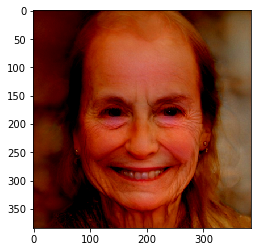

In [29]:
# res = age_model(torch.unsqueeze(b['image'],0))
# print(b['image'].shape)
# plt.imshow(b['image'].permute(1,2,0))
# print(res.shape)
# print(res)
# print(Ages[res.argmax(axis=1)])

In [20]:
%load_ext aicrowd.magic

In [21]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/w9mzF9d_uszrGBMR7QoUIp10-3QiUvgryoYXWJcZdJM
API Key valid
Gitlab access token valid
Saved details successfully!


In [31]:
%aicrowd notebook submit -c age-prediction -a assets --no-verify

<IPython.core.display.Javascript object>

Using notebook: age_cls.ipynb for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...
An unexpected error occured!
cannot unpack non-iterable NoneType object
To get more information, you can run this command with -v.
To increase level of verbosity, you can go upto -vvvvv
